# Classification / Clustering with PyRiemann and ICU waves Data

In [42]:
import sys
print sys.prefix
print sys.version

/opt/mapr/EDSIADM/anaconda2/envs/pyaphp
2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [56]:
import pyodbc
import pandas as pd
import numpy as np
import scipy, sklearn
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import pyriemann
from time import gmtime, strftime
%matplotlib inline
pd.options.mode.chained_assignment = None # to avoid pandas warnings
print "np.__version__ :", np.__version__
print "scipy.__version__ :", scipy.__version__
print "pd.__version__:", pd.__version__
print "sklearn.__version__:", sklearn.__version__

np.__version__ : 1.11.1
scipy.__version__ : 0.18.0
pd.__version__: 0.18.1
sklearn.__version__: 0.17.1


In [77]:
# Load Matrix and target
X = np.load("icu_matrix1.pyriemann.npy")
y = np.load("icu_target1.pyriemann.npy")
X.shape, np.size(y)

((2701, 4, 96), 2701)

In [78]:
print(len(np.nonzero(y)[0]))
print(float(len(np.nonzero(y)[0])) / float(len(y))* 100.)

592
21.9178082192


In [79]:
from sklearn.preprocessing import scale
original_X = X
for case in range(X.shape[0]):
    X[case] = scale(X[case])

In [90]:
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, FgMDM
from sklearn.cross_validation import cross_val_score

# estimate covariances matrices
cov = pyriemann.estimation.Covariances().fit_transform(X)
cov.shape

(2701, 4, 4)

In [91]:
#
# Cov regularization
#
Id = np.eye(cov.shape[1])
# alpha = 1e-01
alpha = 1  # no regularization
for case in range(cov.shape[0]):
    if case == 0:
        print(cov[case])
    cov[case] += alpha*Id
    if case == 0:
        print(cov[case])

[[ 0.05524812 -0.01379255 -0.03346225 -0.00799332]
 [-0.01379255  0.00431128  0.00873074  0.00075053]
 [-0.03346225  0.00873074  0.02112291  0.0036086 ]
 [-0.00799332  0.00075053  0.0036086   0.00363419]]
[[  1.05524812e+00  -1.37925505e-02  -3.34622514e-02  -7.99331647e-03]
 [ -1.37925505e-02   1.00431128e+00   8.73073889e-03   7.50527514e-04]
 [ -3.34622514e-02   8.73073889e-03   1.02112291e+00   3.60859853e-03]
 [ -7.99331647e-03   7.50527514e-04   3.60859853e-03   1.00363419e+00]]


In [92]:
# cross validation
mdm = pyriemann.classification.MDM(metric='riemann')
# mdm = pyriemann.classification.MDM(metric='riemann')
accuracy = cross_val_score(mdm,cov,y, cv=5)

0.690861501456


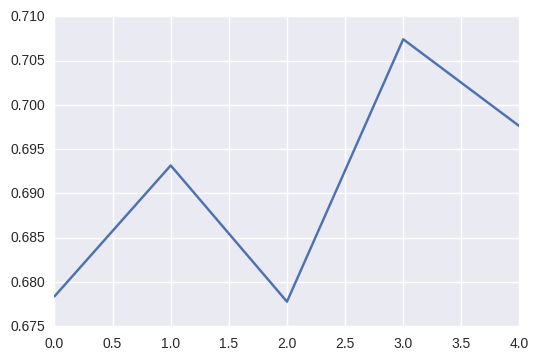

In [93]:
print(accuracy.mean())
plt.plot(range(len(accuracy)), accuracy)